In [1]:
!pip install casadi
from IPython.display import clear_output
import os
import time

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [2]:
g = 9.81 #重力加速度
m = 0.1125 #質点の質量
k = 0.4 #バネ定数
l = 0.1375 #バネの自然長

pos_0 = casadi.DM.zeros(3)
G = casadi.DM([0,0,g])

ns = 5 #バネの個数

nu = 3 #制御変数の次元
nx = 2*3*(ns-1)+3 #状態変数の次元

# コスト関数の重み
Q = casadi.diag([0,0,0]*(ns-1)+[12.5,12.5,12.5]+[125,125,125]*(ns-1))
Q_f = casadi.diag([0,0,0]*(ns-1)+[10,10,10]+[0,0,0]*(ns-1))
R = casadi.diag([0.5,0.5,0.5])

# 予測ホライズン等
T = 2
K = 20
dt = T/K

# 制約条件
x_lb = [-np.inf]*nx
x_ub = [np.inf]*nx
u_lb = [-5]*nu
u_ub = [5]*nu

x_ref = casadi.DM([0,0,0]*(ns-1)+[8,0,0]+[0,0,0]*(ns-1))

total = nx*(K+1) + nu*K

In [3]:
def make_spring_force():
    pos_i = casadi.SX.sym("pos_i",3)
    pos_i1 = casadi.SX.sym("pos_i1",3)
    pos_rel = pos_i1 - pos_i
    norm = casadi.norm_2(pos_rel)
    force = k*(norm - l)*pos_rel/norm

    F = casadi.Function("F",[pos_i,pos_i1],[force],['pos_i','pos_i1'],['F'])
    return F

def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    F = make_spring_force()
    offset = 3*ns

    X_dot = []
    V_dot = []

    for k in range(ns-1):
        vel = states[offset+3*k:offset+3*(k+1)]
        X_dot.append(vel)

        pos = states[3*k:3*(k+1)]
        pos_n = states[3*(k+1):3*(k+2)]
        pos_p = states[3*(k-1):3*k] if k != 0 else pos_0
        vel_dot = (F(pos_i=pos,pos_i1=pos_n)["F"]-F(pos_i=pos_p,pos_i1=pos)["F"])/m - G
        V_dot.append(vel_dot)

    states_dot = casadi.vertcat(*X_dot,ctrls,*V_dot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    x_diff = x - x_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u,u)) / 2
    return cost

def compute_final_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [4]:
def make_nlps():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k])*dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_final_cost(X[-1])

    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    option = {'print_time':False,"ipopt":{'print_level':0}}
    S_ipopt = casadi.nlpsol("S","ipopt",nlp,option)
    
    option = {'print_time':False,
              "print_iteration":False,
              "print_header":False,
              "qpsol_options":{"print_info":False,"print_iter":False,"print_header":False}
              }
    S_qrsqp = casadi.nlpsol("S","qrsqp",nlp,option)
    return S_ipopt, S_qrsqp

In [5]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [6]:
def make_x_init():
    x_init = np.zeros((2*ns-1,3))
    x_init[:ns,0] = np.linspace(0,8,ns+1)[1:]
    x_init[ns+1,1] = 8
    x_init = x_init.ravel()
    x_init = casadi.DM(x_init)
    return x_init

def make_x0(x_init):
    I = make_integrator()
    x0 = [x_init]
    x_tmp = x_init
    for i in range(K):
        x_tmp = I(x0=x_tmp)["xf"]
        x0.append(x_tmp)
    u0 = casadi.DM.zeros(nu*K)
    x0 = casadi.vertcat(*x0,u0)
    return x0

# 自由運動

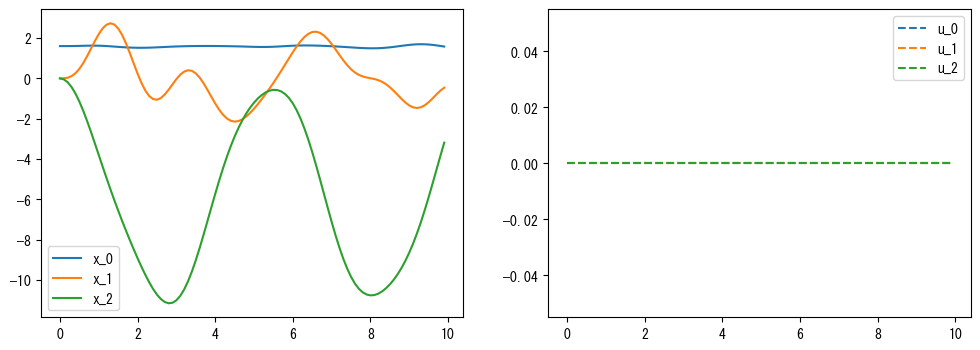

In [7]:
S_ipopt, S_qrsqp = make_nlps()

t_span = [0,10]
t_eval = np.arange(*t_span,dt)
I = make_integrator()

# x_init = casadi.DM([2,0,0,3.5,0,0,5,0,0,6.5,0,0,8,0,0,0,0,0,0,8,0,0,0,0,0,0,0])
x_init = make_x_init()
x0 = make_x0(x_init)

# Times = []
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    # start_time = time.perf_counter()
    # u_opt,x0 = compute_optimal_control(S_ipopt,x_current,x0)
    # Times.append(time.perf_counter() - start_time)
    u_opt = casadi.DM.zeros(nu)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(3):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.show()

# IPOPT


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



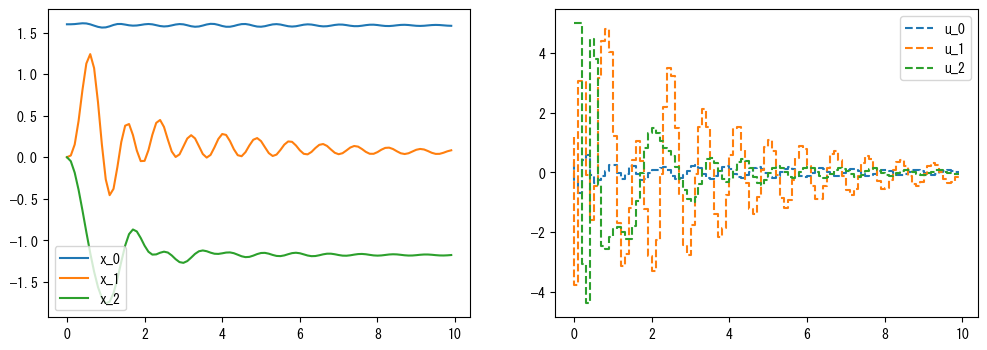

In [8]:
S_ipopt, S_qrsqp = make_nlps()

t_span = [0,10]
t_eval = np.arange(*t_span,dt)
I = make_integrator()

x_init = make_x_init()
x0 = make_x0(x_init)

Times = []
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    start_time = time.perf_counter()
    u_opt,x0 = compute_optimal_control(S_ipopt,x_current,x0)
    Times.append(time.perf_counter() - start_time)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(3):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.show()

[*] solver: ipopt, elapsed time: 0.092492s


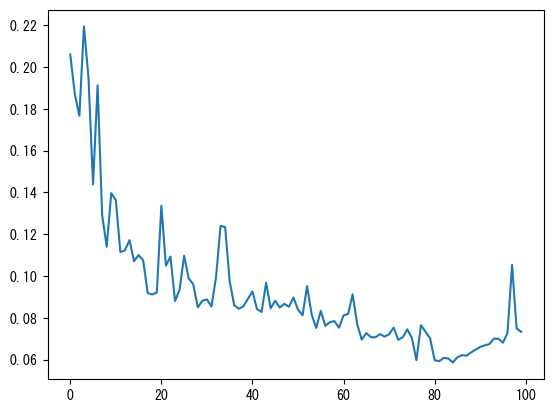

In [10]:
Times = np.array(Times)
print(f"[*] solver: ipopt, elapsed time: {Times.mean():1f}s")
plt.plot(Times)
plt.savefig("images/chap7_nlp_ipopt_time.png")
plt.show()

# qrsqp

MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 iterations
MESSAGE(qrsqp): Convergence achieved after 3 ite

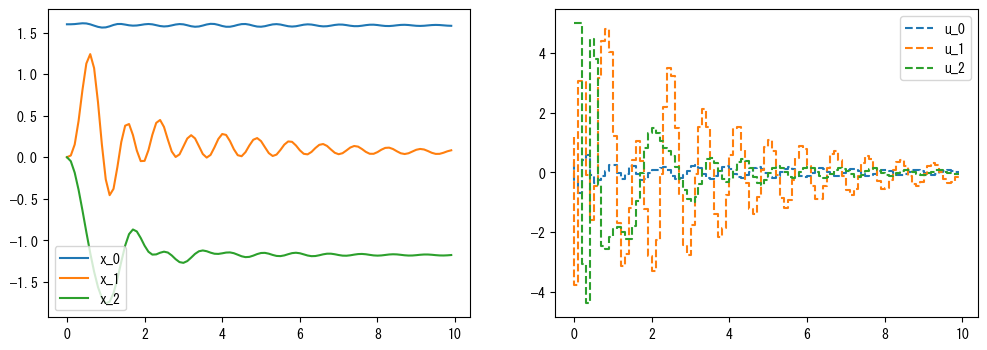

In [11]:
S_ipopt, S_qrsqp = make_nlps()

t_span = [0,10]
t_eval = np.arange(*t_span,dt)
I = make_integrator()

x_init = make_x_init()
x0 = make_x0(x_init)

Times = []
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    start_time = time.perf_counter()
    u_opt,x0 = compute_optimal_control(S_qrsqp,x_current,x0)
    Times.append(time.perf_counter() - start_time)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(3):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.show()

[*] solver: qrsqp, elapsed time: 0.072179s


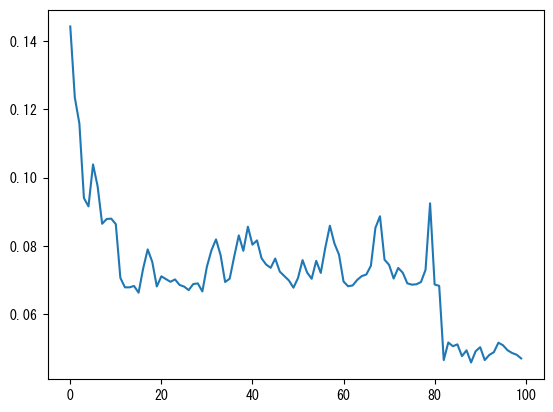

In [12]:
Times = np.array(Times)
print(f"[*] solver: qrsqp, elapsed time: {Times.mean():1f}s")
plt.plot(Times)
plt.savefig("images/chap7_nlp_qrsqp_time.png")
plt.show()

# IPOPT (初期値がランダム)

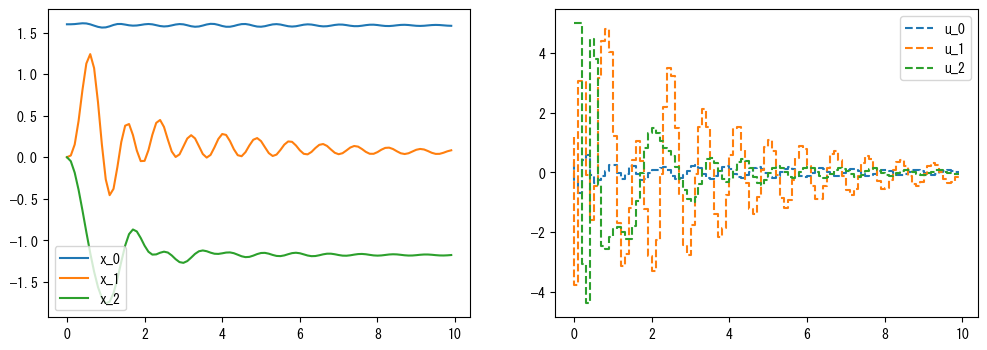

In [13]:
S_ipopt, S_qrsqp = make_nlps()

t_span = [0,10]
t_eval = np.arange(*t_span,dt)
I = make_integrator()

x_init = make_x_init()
x0 = casadi.DM(0.05*np.random.normal(size=total))

Times = []
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    start_time = time.perf_counter()
    u_opt,x0 = compute_optimal_control(S_ipopt,x_current,x0)
    Times.append(time.perf_counter() - start_time)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(3):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.show()

[*] solver: ipopt, elapsed time: 0.098322s


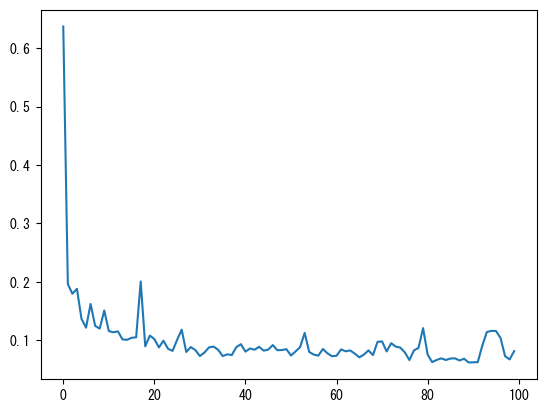

In [14]:
Times = np.array(Times)
print(f"[*] solver: ipopt, elapsed time: {Times.mean():1f}s")
plt.plot(Times)
plt.savefig("images/chap7_nlp_ipopt_time_without_init.png")
plt.show()

# qrsqp（初期値がランダム）

In [15]:
S_ipopt, S_qrsqp = make_nlps()

t_span = [0,10]
t_eval = np.arange(*t_span,dt)
I = make_integrator()

x_init = make_x_init()
x0 = casadi.DM(0.05*np.random.normal(size=total))

Times = []
X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    start_time = time.perf_counter()
    u_opt,x0 = compute_optimal_control(S_qrsqp,x_current,x0)
    Times.append(time.perf_counter() - start_time)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(3):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.show()

Function qpsol (0x209d0995480)
Input 0 (h): sparse: 627-by-627, 16563 nnz
 (0, 0) -> 37258.2
 (1, 0) -> -77984.6
 (2, 0) -> 6862.09
 ...
 (624, 626) -> -7.46428e-315
 (625, 626) -> -1.01476e-313
 (626, 626) -> 0.05
Input 1 (g): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -4.60098, 0.0506731, -0.0115789, -0.3257, -0.33286, 0.24304, -0.435826, 53.9895, 0.035661, 0.147237, -0.313275, 0.322453, 0.0222152, -0.238489, 0.500273, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -7.6233, 0.930916, -0.981431, 8.52865, 10.7195, -7.26255, -11.9231, 56.0797, -3.68992, 5.90928, -7.30387, -4.74335, -14.6011, 11.641, -6.98212, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -9.03563, 1.91968, -2.60048, 6.60003, 12.9738, -6.9056, -47.7445, 52.3338, -30.0451, 34.719, 3.81573, -3.24486, 5.88131, -2.83318, 1.88071, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -12.0474, 0.953777, -4.69059, 57.8119, -14.6988, -21.1053, -63.3513, 26.5023, -23.6228, 23.5984, 28.1985, -35.5284, -22.0676, 27.9544, 6.00307, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -14.151, 

RuntimeError: Error in Function::call for 'S' [Qrsqp] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'S' [Qrsqp] at .../casadi/core/function.cpp:330:
Error in Function::operator() for 'qpsol' [Qrqp] at .../casadi/core/function.cpp:1482:
.../casadi/core/conic.cpp:537: conic process failed. Set 'error_on_fail' option to false to ignore this error.

In [ ]:
# Times = np.array(Times)
# print(f"[*] solver: qrsqp, elapsed time: {Times.mean():1f}s")
# plt.plot(Times)
# plt.savefig("images/chap7_nlp_qrsqp_time_without_init.png")
# plt.show()

In [ ]:
# fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot(111,projection="3d")
# frames = np.arange(0,t_eval.size)
# fps = 1 / dt

# def update_figure(i):
#     x_lim_min = -1
#     x_lim_max = 8
#     y_lim_min = -1
#     y_lim_max = 1
#     z_lim_min = -3
#     z_lim_max = 1
#     u_scale = 3

#     ax.cla()
#     ax.set_xlim(x_lim_min, x_lim_max)
#     ax.set_ylim(y_lim_min, y_lim_max)
#     ax.set_zlim(z_lim_min, z_lim_max)
#     ax.view_init(elev=5,azim=-75)

#     points = X[i,:3*ns]
#     points = np.concatenate([np.zeros(3),points])
#     points = points.reshape(-1,3)
#     vel = U[i]

#     ax.scatter(*points.T,color="black", s=2)
#     ax.plot(*points.T, color='black', lw=2)
#     ax.quiver(*points[-1],*vel/u_scale, length=1.0,normalize=False)

#     left = np.zeros(3)
#     right = x_ref.full().ravel()[3*(ns-1):3*ns]
#     ax.scatter(*left,color="green", s=10)
#     ax.scatter(*right,color="blue", s=10)

# ani = FuncAnimation(fig, update_figure, frames=frames)
# ani.save("images/chap7_chain_of_mass.gif",writer="pillow",fps=fps)

In [ ]:
# import glob
# import natsort
# import cv2
# for i in np.linspace(0,199,12):
#     i = int(i)
#     update_figure(i)
#     fig.savefig(f"./tmp/_frame_{i}.png")
# paths = glob.glob("./tmp/*.png")
# paths = natsort.natsorted(paths)
# paths = [cv2.imread(path) for path in paths]
# paths = np.stack(paths,axis=0)
# paths = paths.reshape(4,3,600,1200,3)
# paths = np.concatenate(paths,axis=1)
# paths = np.concatenate(paths,axis=1)
# # paths = cv2.resize(paths,dsize=None,fx=1/3,fy=1/3)
# cv2.imwrite("images/chap5_cart_pole_anim.png",paths)